In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import model_20250904
import simulate
from sklearn.metrics import r2_score
import importlib


In [15]:
device = "cpu"
random_seed = 2025
r2 = 0.5
n = 1000
dim = 112
coord, true_beta, img_data, y = simulate.simulate_data(n, r2, dim, random_seed)

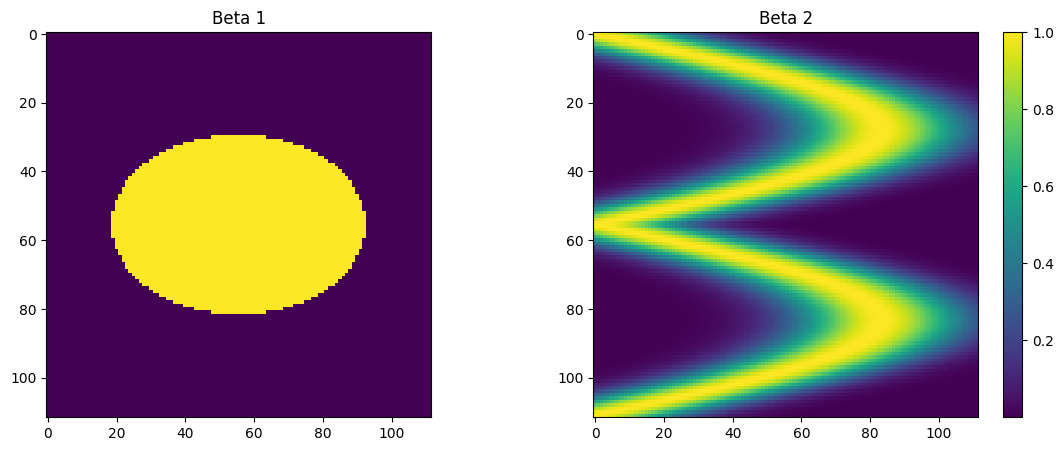

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (14,5))
axs[0].imshow(true_beta[0].reshape(dim, dim))
axs[0].set_title("Beta 1")

cax = axs[1].imshow(true_beta[1].reshape(dim, dim))
axs[1].set_title("Beta 2")

fig.colorbar(cax, ax = axs[1])
plt.show()



In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

img_data_0_flat = img_data[0].reshape(n, -1)
img_data_1_flat = img_data[1].reshape(n, -1)

concatenated_img = np.concatenate([img_data_0_flat, img_data_1_flat], axis=1)

concatenated_img_tensor = torch.tensor(concatenated_img, dtype=torch.float32).to(device)
    
input_size = 2 * dim * dim

y = y.reshape(-1, 1)
y_tensor = torch.tensor(y, dtype = torch.float32).to(device)

torch.manual_seed(random_seed)
np.random.seed(random_seed)

X_train, X_test, y_train, y_test = train_test_split(concatenated_img_tensor, y_tensor, test_size = 0.2, random_state = random_seed)
train_dataset = TensorDataset(X_train, y_train)
test_dataset =  TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

In [18]:
import model_20250904
importlib.reload(model_20250904)      # Force-reload the module
from model_20250904 import DNN_5_512, DNN_5_256 , DNN_5_128        # Import the updated class

In [19]:
def train_dnn_model(model_class=model_20250904.DNN_5_512, 
                    lr=0.001, 
                    weight_decay=0.0, 
                    num_epochs=20, 
                    train_loader=None, 
                    test_loader=None, 
                    device='cuda' if torch.cuda.is_available() else 'cpu',
                    verbose=True,
                    plot_results=True):
    """
    Train a DNN model with customizable parameters and track performance metrics.
    
    Args:
        model_class: DNN model class (default: DNN_5_512)
        lr: Learning rate (default: 0.001)
        weight_decay: L2 regularization (default: 0.0)
        num_epochs: Number of training epochs (default: 20)
        train_loader: Training data loader
        test_loader: Test/validation data loader
        device: Device to run training on
        verbose: Whether to print training progress
        plot_results: Whether to plot learning curves
    
    Returns:
        Dictionary containing training history and best metrics
    """
    # Initialize model, criterion and optimizer
    dnn = model_class(input_size=input_size).to(device)
    criterion = torch.nn.MSELoss()
    optimizer = optim.Adam(dnn.parameters(), lr=lr, weight_decay=weight_decay)

    # Initialize lists to track metrics
    train_losses = []
    test_losses = []
    all_train_r2 = []
    all_test_r2 = []
    
    best_epoch = 0
    best_test_loss = float('inf')
    best_test_r2 = -float('inf')

    for epoch in range(num_epochs):
        # --- Training Phase ---
        dnn.train()
        running_loss = 0.0
        y_pred, y_true = [], []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_hat_batch = dnn(X_batch)
            loss = criterion(y_hat_batch, y_batch)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                running_loss += loss.item()
                y_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
                y_true.extend(y_batch.cpu().numpy().flatten())
        
        # Calculate training metrics
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)
        train_r2 = r2_score(y_true, y_pred)
        all_train_r2.append(train_r2)
        
        # --- Validation/Test Phase ---
        dnn.eval()
        with torch.no_grad():
            test_pred, test_true = [], []
            test_running_loss = 0.0
            
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_hat_batch = dnn(X_batch)
                loss = criterion(y_hat_batch, y_batch)
                test_running_loss += loss.item()
                test_pred.extend(y_hat_batch.detach().cpu().numpy().flatten())
                test_true.extend(y_batch.cpu().numpy().flatten())
            
            epoch_test_loss = test_running_loss / len(test_loader)
            test_losses.append(epoch_test_loss)
            test_r2 = r2_score(test_true, test_pred)
            all_test_r2.append(test_r2)
            
            # Update best epoch
            if epoch_test_loss < best_test_loss:
                best_test_loss = epoch_test_loss
                best_test_r2 = test_r2
                best_epoch = epoch + 1
        
        # Print metrics if verbose
        # if verbose and (epoch + 1) % 1 == 0:
        #     print(f"Epoch {epoch + 1}/{num_epochs}")
        #     print(f"  Train Loss: {epoch_train_loss:.4f} ± {np.std(train_losses):.4f}")
        #     print(f"  Train R²: {train_r2:.4f} ± {np.std(all_train_r2):.4f}")
        #     print(f"  Test Loss: {epoch_test_loss:.4f} ± {np.std(test_losses):.4f}")
        #     print(f"  Test R²: {test_r2:.4f} ± {np.std(all_test_r2):.4f}\n")

    # Final summary
    if verbose:
        print(f"\n=== {model_class.__name__} Training Summary ===")
        print(f"Best Epoch: {best_epoch}")
        print(f"Best Test Loss: {best_test_loss:.4f}")
        print(f"Corresponding Test R²: {best_test_r2:.4f}")
        print(f"Final Train Loss: {train_losses[-1]:.4f} ± {np.std(train_losses):.4f}")
        print(f"Final Train R²: {all_train_r2[-1]:.4f} ± {np.std(all_train_r2):.4f}")
        print(f"Final Test Loss: {test_losses[-1]:.4f} ± {np.std(test_losses):.4f}")
        print(f"Final Test R²: {all_test_r2[-1]:.4f} ± {np.std(all_test_r2):.4f}")

    # Plot results if requested
    if plot_results:
        plt.figure(figsize=(12, 5))

        # Plot Losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title(f'{model_class.__name__} Training & Test Loss')
        plt.legend()

        # Plot R² Scores
        plt.subplot(1, 2, 2)
        plt.plot(all_train_r2, label='Train R²')
        plt.plot(all_test_r2, label='Test R²')
        plt.xlabel('Epoch')
        plt.ylabel('R² Score')
        plt.title(f'{model_class.__name__} R² Scores')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return {
        'model': dnn,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_r2_scores': all_train_r2,
        'test_r2_scores': all_test_r2,
        'best_epoch': best_epoch,
        'best_test_loss': best_test_loss,
        'best_test_r2': best_test_r2,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'final_train_r2': all_train_r2[-1],
        'final_test_r2': all_test_r2[-1]
    }

# Example usage:
# results = train_dnn_model(model_class=model.DNN_5_512,
#                         lr=0.0001,
#                         weight_decay=0.01,
#                         num_epochs=100,
#                         train_loader=train_loader,
#                         test_loader=test_loader)

In [20]:
import model_20250904
importlib.reload(model_20250904)      # Force-reload the module
from model_20250904 import DNN_5_512, DNN_5_256 , DNN_5_128        # Import the updated class


=== DNN_5_512 Training Summary ===
Best Epoch: 7
Best Test Loss: 90.9143
Corresponding Test R²: 0.4001
Final Train Loss: 29.9257 ± 24.5144
Final Train R²: 0.8072 ± 0.1580
Final Test Loss: 106.3121 ± 6.7384
Final Test R²: 0.3126 ± 0.0416


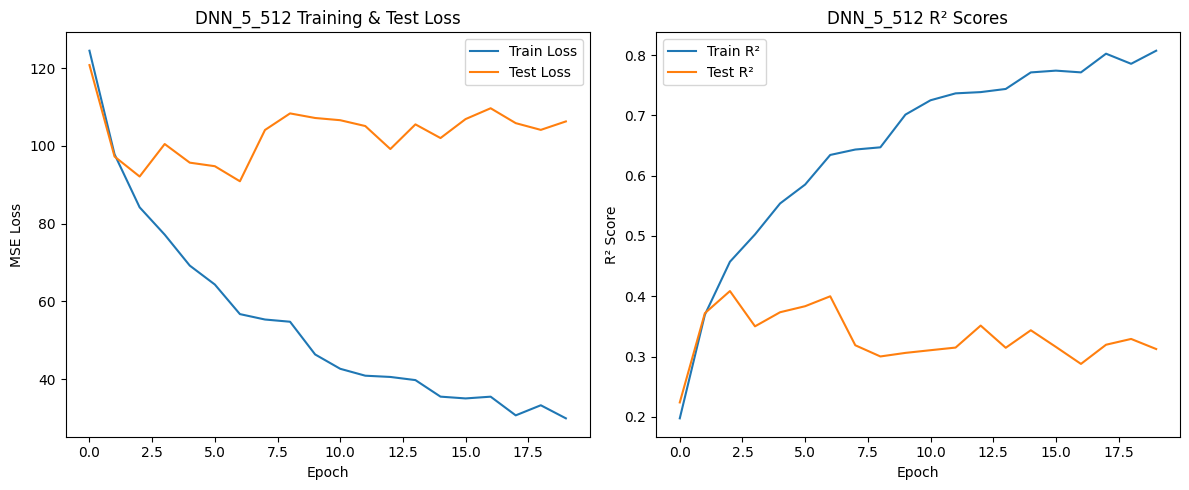

In [21]:
# session 1
results = train_dnn_model(model_class=model_20250904.DNN_5_512,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== DNN_5_512 Training Summary ===
Best Epoch: 17
Best Test Loss: 105.4524
Corresponding Test R²: 0.3244
Final Train Loss: 45.8940 ± 28.6637
Final Train R²: 0.7043 ± 0.1847
Final Test Loss: 105.8953 ± 11.8185
Final Test R²: 0.3216 ± 0.0771


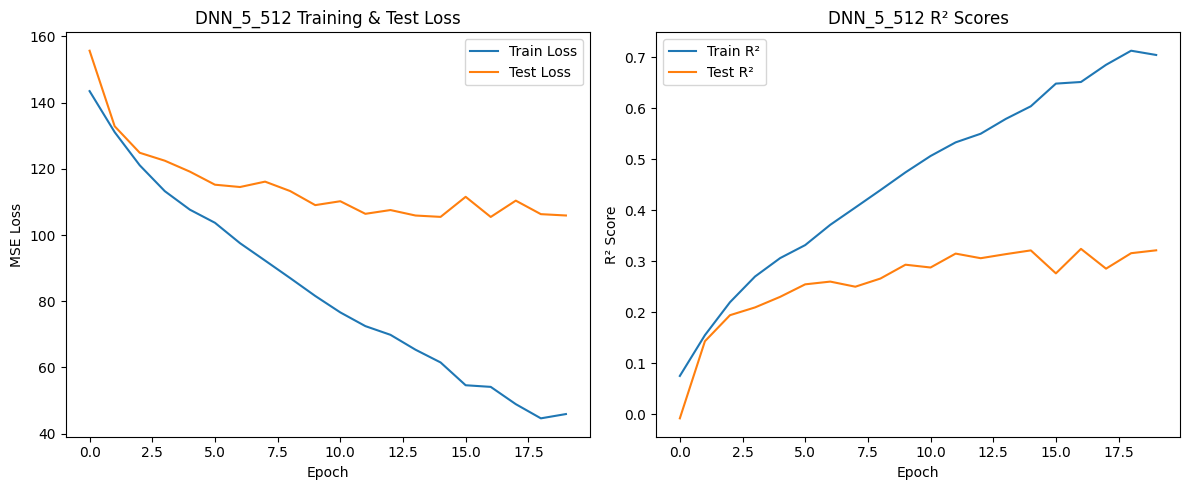

In [22]:
# session 2 
results = train_dnn_model(model_class=model_20250904.DNN_5_512,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== DNN_5_256 Training Summary ===
Best Epoch: 6
Best Test Loss: 94.3325
Corresponding Test R²: 0.3934
Final Train Loss: 42.2474 ± 27.8340
Final Train R²: 0.7278 ± 0.1794
Final Test Loss: 101.3392 ± 8.2427
Final Test R²: 0.3462 ± 0.0533


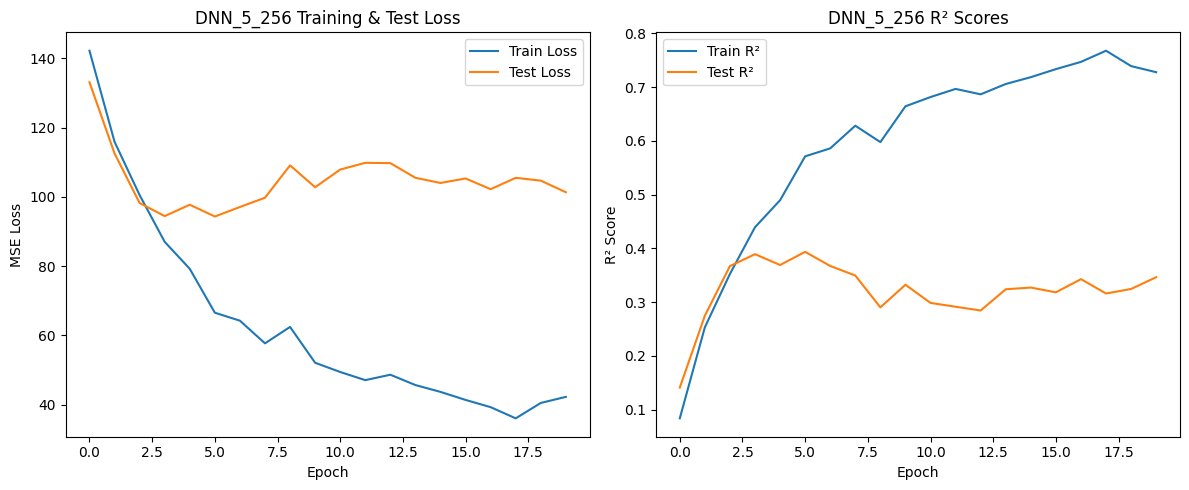

In [23]:
# session 3 
results = train_dnn_model(model_class=model_20250904.DNN_5_256,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== DNN_5_256 Training Summary ===
Best Epoch: 20
Best Test Loss: 112.8983
Corresponding Test R²: 0.2712
Final Train Loss: 85.1507 ± 19.3508
Final Train R²: 0.4513 ± 0.1247
Final Test Loss: 112.8983 ± 10.5821
Final Test R²: 0.2712 ± 0.0686


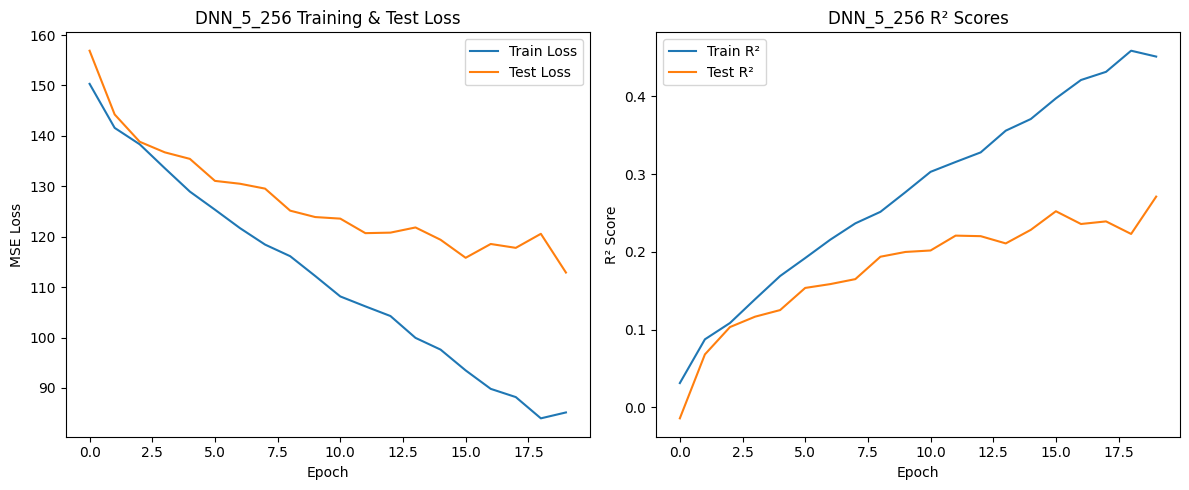

In [24]:
# session 4
results = train_dnn_model(model_class=model_20250904.DNN_5_256,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== DNN_5_128 Training Summary ===
Best Epoch: 7
Best Test Loss: 93.4926
Corresponding Test R²: 0.3990
Final Train Loss: 46.0678 ± 28.9001
Final Train R²: 0.7031 ± 0.1862
Final Test Loss: 105.1402 ± 11.5101
Final Test R²: 0.3212 ± 0.0744


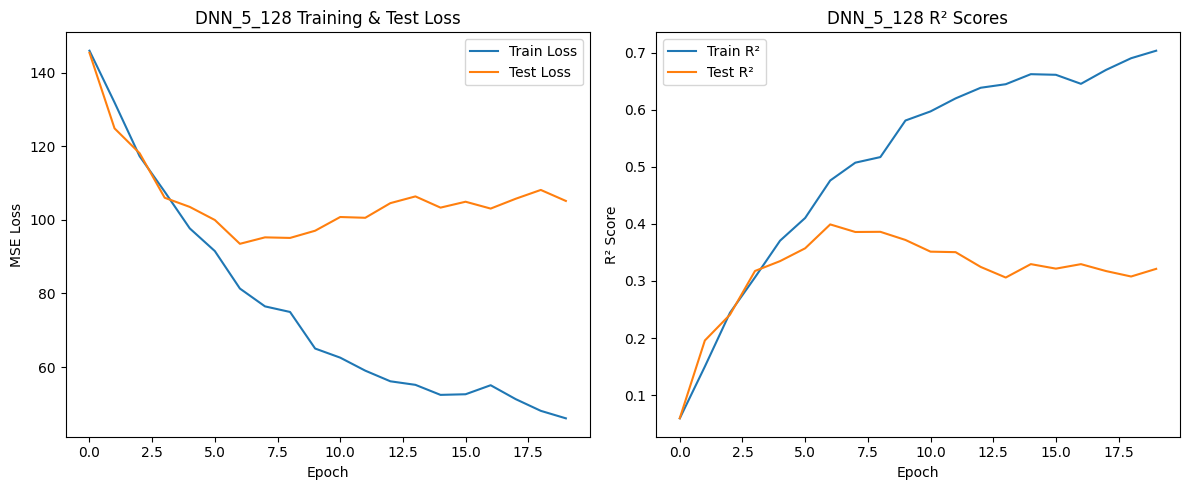

In [25]:
# session 5
results = train_dnn_model(model_class=model_20250904.DNN_5_128,
                        lr=0.001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)


=== DNN_5_128 Training Summary ===
Best Epoch: 19
Best Test Loss: 131.7237
Corresponding Test R²: 0.1507
Final Train Loss: 114.0966 ± 11.0021
Final Train R²: 0.2648 ± 0.0709
Final Test Loss: 132.2018 ± 6.6814
Final Test R²: 0.1480 ± 0.0439


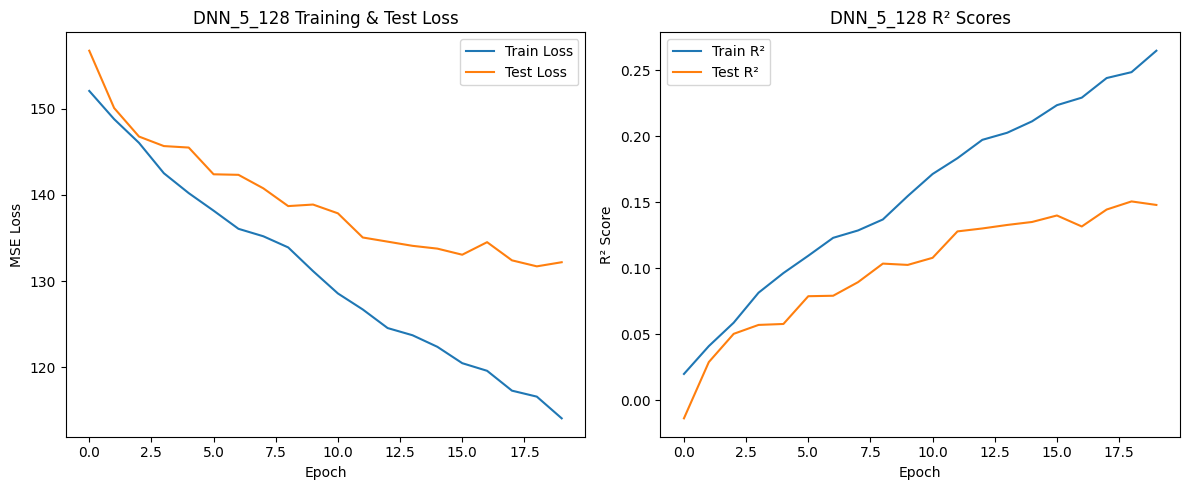

In [26]:
# session 6

results = train_dnn_model(model_class=model_20250904.DNN_5_128,
                        lr=0.0001,
                        weight_decay=0.0,
                        num_epochs=20,
                        train_loader=train_loader,
                        test_loader=test_loader)